In [2]:
import os
import re
import pandas as pd
import pdfplumber
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

pts = []

In [3]:
class Rectangle:
    """
    A class to represent a rectangular area with coordinates and dimensions.
    
    Attributes:
        coords (list): Four corner coordinates of the rectangle
        centroid (list): Coordinates of the rectangle's center point
        width (float): Width of the rectangle
        height (float): Height of the rectangle
    """
    def __init__(
        self, bl_coord: tuple[float, float], width: float, height: float
    ) -> None:
        """
        Initialize a Rectangle object.
        
        Args:
            bl_coord (tuple): Bottom-left coordinate (x, y)
            width (float): Width of the rectangle
            height (float): Height of the rectangle
        """
        # Calculate rectangle coordinates based on bottom-left point
        self.coords = [
            list(bl_coord),  # Bottom-left point
            [bl_coord[0] + width, bl_coord[1] - height],  # Bottom-right point
            [bl_coord[0] + width, bl_coord[1] + height],  # Top-right point
            [bl_coord[0], bl_coord[1] + height],  # Top-left point
        ]
        # Calculate rectangle's center point
        self.centroid = [bl_coord[0] + (width / 2), bl_coord[1] + (height / 2)]
        
        self.width = width
        self.height = height


def get_positions(filepath):
    """
    Extract player positions from a PDF file.
    
    Args:
        filepath (str): Path to the PDF file
    
    Returns:
        List of position groups for both teams
    """
    # Open the PDF and extract tables from the second page
    with pdfplumber.open(filepath) as pdf:
        page = pdf.pages[1]
        page_tables = page.extract_tables()

    # Extract position strings using regex
    positions = re.findall(r"[A-Z]{2,}", page_tables[0][2][0])

    # Split positions into two teams
    team_1_positions = positions[::2]
    team_2_positions = positions[1::2]

    # Reference list of standard positions
    position_ref = ["B", "DMF", "CM", "AM", "W", "CF"]

    team_position_groups = []

    # Group positions for each team
    for team in [team_1_positions, team_2_positions]:
        position_groups = {}
        for position in position_ref:
            # Filter positions that match each reference position
            filtered_strings = list(filter(lambda x: position in x, team[:11]))
            position_groups[position] = filtered_strings
            team_position_groups.append(position_groups)


def get_field_length(curves):
    """
    Calculate the length and width of the field based on curve coordinates.
    
    Args:
        curves (list): List of curve objects from PDF
    
    Returns:
        tuple: Y-length and X-length of the field
    """
    # Iterate through curves to find field boundaries
    for curve in curves:
        # Check if curve is within expected field coordinates
        if 15 < curve["x0"] < 24 and curve["y0"] < 300:
            x0, x1, y0, y1 = curve["x0"], curve["x1"], curve["y0"], curve["y1"]
            # Calculate absolute lengths
            x_length = abs(x1 - x0)
            y_length = abs(y1 - y0)

    return y_length, x_length


def calculate_area(x1, x2, y1, y2):
    """
    Calculate the area of a rectangle.
    
    Args:
        x1 (float): X-coordinate of first point
        x2 (float): X-coordinate of second point
        y1 (float): Y-coordinate of first point
        y2 (float): Y-coordinate of second point
    
    Returns:
        float: Area of the rectangle
    """
    # Calculate side lengths using absolute differences
    side_a = abs(x2 - x1)
    side_b = abs(y2 - y1)

    # Calculate rectangle area
    area = side_a * side_b

    return area


def get_positions_and_names(filepath):
    """
    Extract player positions and names from a PDF file.
    
    Args:
        filepath (str): Path to the PDF file
    
    Returns:
        tuple: Positions for the first 11 players of each team
    """
    # Open PDF and extract tables from second page
    with pdfplumber.open(filepath) as pdf:
        page = pdf.pages[1]
        page_tables = page.extract_tables()

    # Extract positions and names using regex
    positions = re.findall(r"[A-Z]{2,}", page_tables[0][2][0])
    names = re.findall(r"[A-Z]\. [A-Za-z]+", page_tables[0][2][0])

    # Split positions and names into teams
    team_1_positions = positions[::2]
    team_2_positions = positions[1::2]

    team_1_names = names[::2]
    team_2_names = names[1::2]

    # Separate starters and substitutes
    team_1_starters = team_1_names[:11]
    team_1_subs = team_1_names[11 : len(team_1_positions)]

    team_2_starters = team_2_names[:11]
    team_2_subs = team_2_names[11 : len(team_2_positions)]

    return team_1_positions[:11], team_2_positions[:11]


def extract_shot_loc(curves, rects):
    """
    Extract shot locations from curves and rectangles.
    
    Args:
        curves (list): List of curve objects
        rects (list): List of rectangle objects
    
    Returns:
        list: Centroids of shot locations
    """
    # Initialize tracking variables for shot boundaries
    min_x = 100
    max_x = 0

    centroids = []

    # lower_threshold = 8
    upper_threshold = 100
    # Process curves to find shot locations
    for curve in curves:
        if len(curve['pts']) > upper_threshold or len(curve['pts']) == 6:
            continue
        pts.append(len(curve['pts']))
        x0, x1, y0, y1 = curve["x0"], curve["x1"], curve["y0"], curve["y1"]

        x_length = abs(x1 - x0)
        y_length = abs(y1 - y0)

        points = curve["pts"]
        area = calculate_area(x0, x1, y0, y1)

        # Filter for potential shot locations based on area and position
        if area < 300 and y0 < 790 and y0 > 600:
            # Track minimum and maximum x coordinates
            if x0 < min_x:
                min_x = x0
                min_coords = [x0, y1]

            if x1 > max_x:
                max_x = x1
                max_coords = [x1, y1]

            # Add shot location centroid if within vertical range
            if y1 < 768:
                rect = Rectangle([x0, y0], x_length, y_length)
                centroids.append(rect.centroid)



    # Repeat similar process for rectangles
    for rect in rects:
        x0, x1, y0, y1 = rect["x0"], rect["x1"], rect["y0"], rect["y1"]

        x_length = x0 - x1
        y_length = y1 - y0

        area = calculate_area(x0, x1, y0, y1)

        # Similar filtering as with curves
        if area < 300 and rect["y0"] < 790 and rect["y0"] > 600:
            if x0 < min_x:
                min_x = x0
                min_coords = [x0, y1]

            if x1 > max_x:
                max_x = x1
                max_coords = [x1, y1]

            if y1 < 768:
                rect = Rectangle([x0, y0], x_length, y_length)
                centroids.append(rect.centroid)
    
    return centroids


def initial_extraction(filepath, page_num):
    """
    Extract initial data from a specific page of a PDF.
    
    Args:
        filepath (str): Path to the PDF file
        page_num (int): Page number to extract data from
    
    Returns:
        tuple: Curves, rectangles, and page tables
    """
    # Open PDF and extract specific page objects and tables
    with pdfplumber.open(filepath) as pdf:
        page = pdf.pages[page_num]
        objects = page.objects
        curves = objects.get("curve", [])
        rects = objects.get("rect", [])

        page_tables = page.extract_tables()
    
    return curves, rects, page_tables


def get_formation(positions):
    """
    Group player positions into predefined categories.
    
    Args:
        positions (list): List of player positions
    
    Returns:
        dict: Dictionary of positions grouped by categories
    """
    # List of position groups to categorize players
    position_groups = ["B", "DMF", "CM", "AM", "W", "CF"]

    positions_group_dict = {}

    # Filter and group positions
    for position in position_groups:
        filtered_strings = list(filter(lambda x: position in x, positions))
        positions_group_dict[position] = filtered_strings

    return positions_group_dict


def parse_shot_locs(src_folder: str, team: str):
    """
    Parse shot locations from PDF files in a source folder.
    
    Args:
        src_folder (str): Path to folder containing PDF files
        team (str): Team name to process
    
    Returns:
        pandas.DataFrame: Shot location data for the specified team
    """
    # Initialize final DataFrame to store results
    final = pd.DataFrame()
    file_names = os.listdir(src_folder)

    # Handle empty folder or system files
    if not file_names:
        return None

    if ".DS_Store" in file_names:
        file_names.remove(".DS_Store")

    # Process each file in the source folder
    for file in file_names:
        # Extract positions for both teams
        team_1_positions, team_2_positions = get_positions_and_names(
            f"{src_folder}/{file}"
        )
        
        # Iterate through pages to find shot data
        for i in range(11, 15):
            # Extract data for team 1
            team_1_curves, team_1_rects, team_1_text = initial_extraction(
                f"{src_folder}/{file}", i
            )
            
            # Check if current page contains shot data
            if "SHOTS" in team_1_text[0][0][0].split("\n"):
                team_1_name = team_1_text[0][0][0].split("\n")[0]
                match_date = re.findall(r"\((.*?)\)", team_1_text[0][0][0])[-1].replace(
                    ".", "-"
                )

                # Extract shot locations and field dimensions
                team_1_centroids = extract_shot_loc(team_1_curves, team_1_rects)
                y_length, x_length = get_field_length(team_1_curves)

                # Calculate translation factors for normalization
                length_translation = 60 / y_length
                width_translation = 75 / x_length

                # Create DataFrame for team 1 shot positions
                team_1_shot_pos = pd.DataFrame(
                    {
                        "team_name": team_1_name,
                        "length": [centroid[1] for centroid in team_1_centroids],
                        "width": [centroid[0] for centroid in team_1_centroids],
                    }
                )
                # Translate shot positions to normalized coordinates
                team_1_shot_pos["length_translated"] = (
                    60 - (team_1_shot_pos["length"] - 286.74831) * length_translation
                )
                team_1_shot_pos["width_translated"] = (
                    75
                    - (team_1_shot_pos["width"] - 22.152230000000003)
                    * width_translation
                )
                team_1_shot_pos["matchdate"] = pd.to_datetime(match_date, dayfirst=True)

                break

        # Repeat similar process for team 2
        team_2_curves, team_2_rects, team_2_text = initial_extraction(
            f"{src_folder}/{file}", i + 1
        )
        
        # Check if current page contains shot data for team 2
        if "SHOTS" in team_2_text[0][0][0].split("\n"):
            team_2_name = team_2_text[0][0][0].split("\n")[0]
            match_date = re.findall(r"\((.*?)\)", team_2_text[0][0][0])[-1].replace(
                ".", "-"
            )

            # Extract shot locations and field dimensions
            team_2_centroids = extract_shot_loc(team_2_curves, team_2_rects)
            y_length, x_length = get_field_length(team_2_curves)

            length_translation = 60 / y_length
            width_translation = 75 / x_length

            # Create DataFrame for team 2 shot positions
            team_2_shot_pos = pd.DataFrame(
                {
                    "team_name": team_2_name,
                    "length": [centroid[1] for centroid in team_2_centroids],
                    "width": [centroid[0] for centroid in team_2_centroids],
                }
            )
            # Translate shot positions to normalized coordinates
            team_2_shot_pos["length_translated"] = (
                60 - (team_2_shot_pos["length"] - 286.74831) * length_translation
            )
            team_2_shot_pos["width_translated"] = (
                75 - (team_2_shot_pos["width"] - 22.152230000000003) * width_translation
            )
            team_2_shot_pos["matchdate"] = pd.to_datetime(match_date, dayfirst=True)

        # Add opponent and defensive line information
        team_1_shot_pos["opp_backline_num"] = len(get_formation(team_2_positions)["B"])
        team_1_shot_pos["backline_num"] = len(get_formation(team_1_positions)["B"])

        team_2_shot_pos["opp_backline_num"] = len(get_formation(team_1_positions)["B"])
        team_2_shot_pos["backline_num"] = len(get_formation(team_2_positions)["B"])

        # Add opponent team names
        team_1_shot_pos["opponent_team_name"] = team_2_name
        team_2_shot_pos["opponent_team_name"] = team_1_name

        # Concatenate results
        final = pd.concat([final, team_1_shot_pos, team_2_shot_pos])

    return final

In [4]:
# Replace with your PDF path
teamname = "Northwestern Wildcats"
game = "01-10-2024"
pdf_path = f"../northwestern-2024"
data = parse_shot_locs(pdf_path, teamname)

In [5]:
data

,team_name,length,width,length_translated,width_translated,matchdate,opp_backline_num,backline_num,opponent_team_name
0,Washington Huskies,627.995827,297.713818,-42.983475,-7.457004,2024-09-21,4,4,Northwestern Wildcats
1,Washington Huskies,627.995827,297.713818,-42.983475,-7.457004,2024-09-21,4,4,Northwestern Wildcats
2,Washington Huskies,627.995827,297.713818,-42.983475,-7.457004,2024-09-21,4,4,Northwestern Wildcats
3,Washington Huskies,757.643244,332.277089,-82.109155,-17.799461,2024-09-21,4,4,Northwestern Wildcats
4,Washington Huskies,757.643244,332.277089,-82.109155,-17.799461,2024-09-21,4,4,Northwestern Wildcats
...,...,...,...,...,...,...,...,...,...
2,DePaul Blue Demons,757.676248,434.205377,-82.119115,-48.299725,2024-08-25,4,4,Northwestern Wildcats
3,DePaul Blue Demons,757.676248,434.205377,-82.119115,-48.299725,2024-08-25,4,4,Northwestern Wildcats
4,DePaul Blue Demons,628.002471,434.155457,-42.985479,-48.284787,2024-08-25,4,4,Northwestern Wildcats
5,DePaul Blue Demons,628.002471,434.155457,-42.985479,-48.284787,2024-08-25,4,4,Northwestern Wildcats


In [6]:
# Round all values in the DataFrame to 2 decimal places
data = data.round(1)
data = data.drop_duplicates().reset_index(drop=True)
data.shape

(249, 9)

In [7]:
data

,team_name,length,width,length_translated,width_translated,matchdate,opp_backline_num,backline_num,opponent_team_name
0,Washington Huskies,628.0,297.7,-43.0,-7.5,2024-09-21,4,4,Northwestern Wildcats
1,Washington Huskies,757.6,332.3,-82.1,-17.8,2024-09-21,4,4,Northwestern Wildcats
2,Washington Huskies,628.0,434.2,-43.0,-48.3,2024-09-21,4,4,Northwestern Wildcats
3,Washington Huskies,628.0,153.0,-43.0,35.8,2024-09-21,4,4,Northwestern Wildcats
4,Washington Huskies,674.6,434.2,-57.0,-48.3,2024-09-21,4,4,Northwestern Wildcats
...,...,...,...,...,...,...,...,...,...
244,Northwestern Wildcats,757.6,153.0,-82.1,35.8,2024-08-25,4,4,DePaul Blue Demons
245,Northwestern Wildcats,637.3,431.6,-45.8,-47.5,2024-08-25,4,4,DePaul Blue Demons
246,DePaul Blue Demons,674.5,60.1,-57.0,63.6,2024-08-25,4,4,Northwestern Wildcats
247,DePaul Blue Demons,757.7,434.2,-82.1,-48.3,2024-08-25,4,4,Northwestern Wildcats


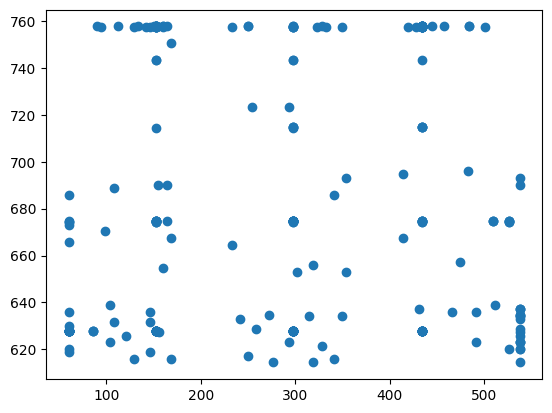

In [8]:
x = np.array(data['width'])
y = np.array(data['length'])
plt.figure()
plt.scatter(x, y)
plt.show()

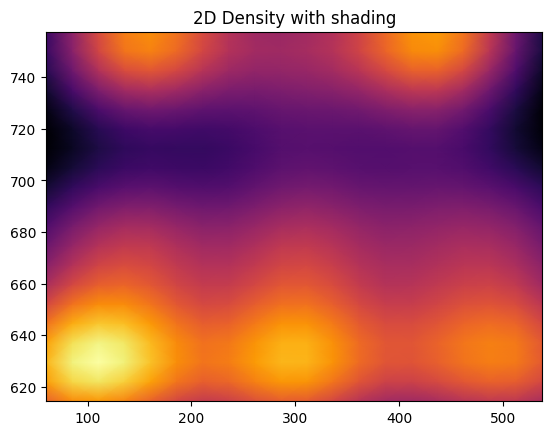

In [9]:
x = np.array(x)
y = np.array(y)

data = np.vstack([x, y])

nbins = 20

k = gaussian_kde(data)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# add shading
plt.figure()
plt.title('2D Density with shading')
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap='inferno')
plt.show()

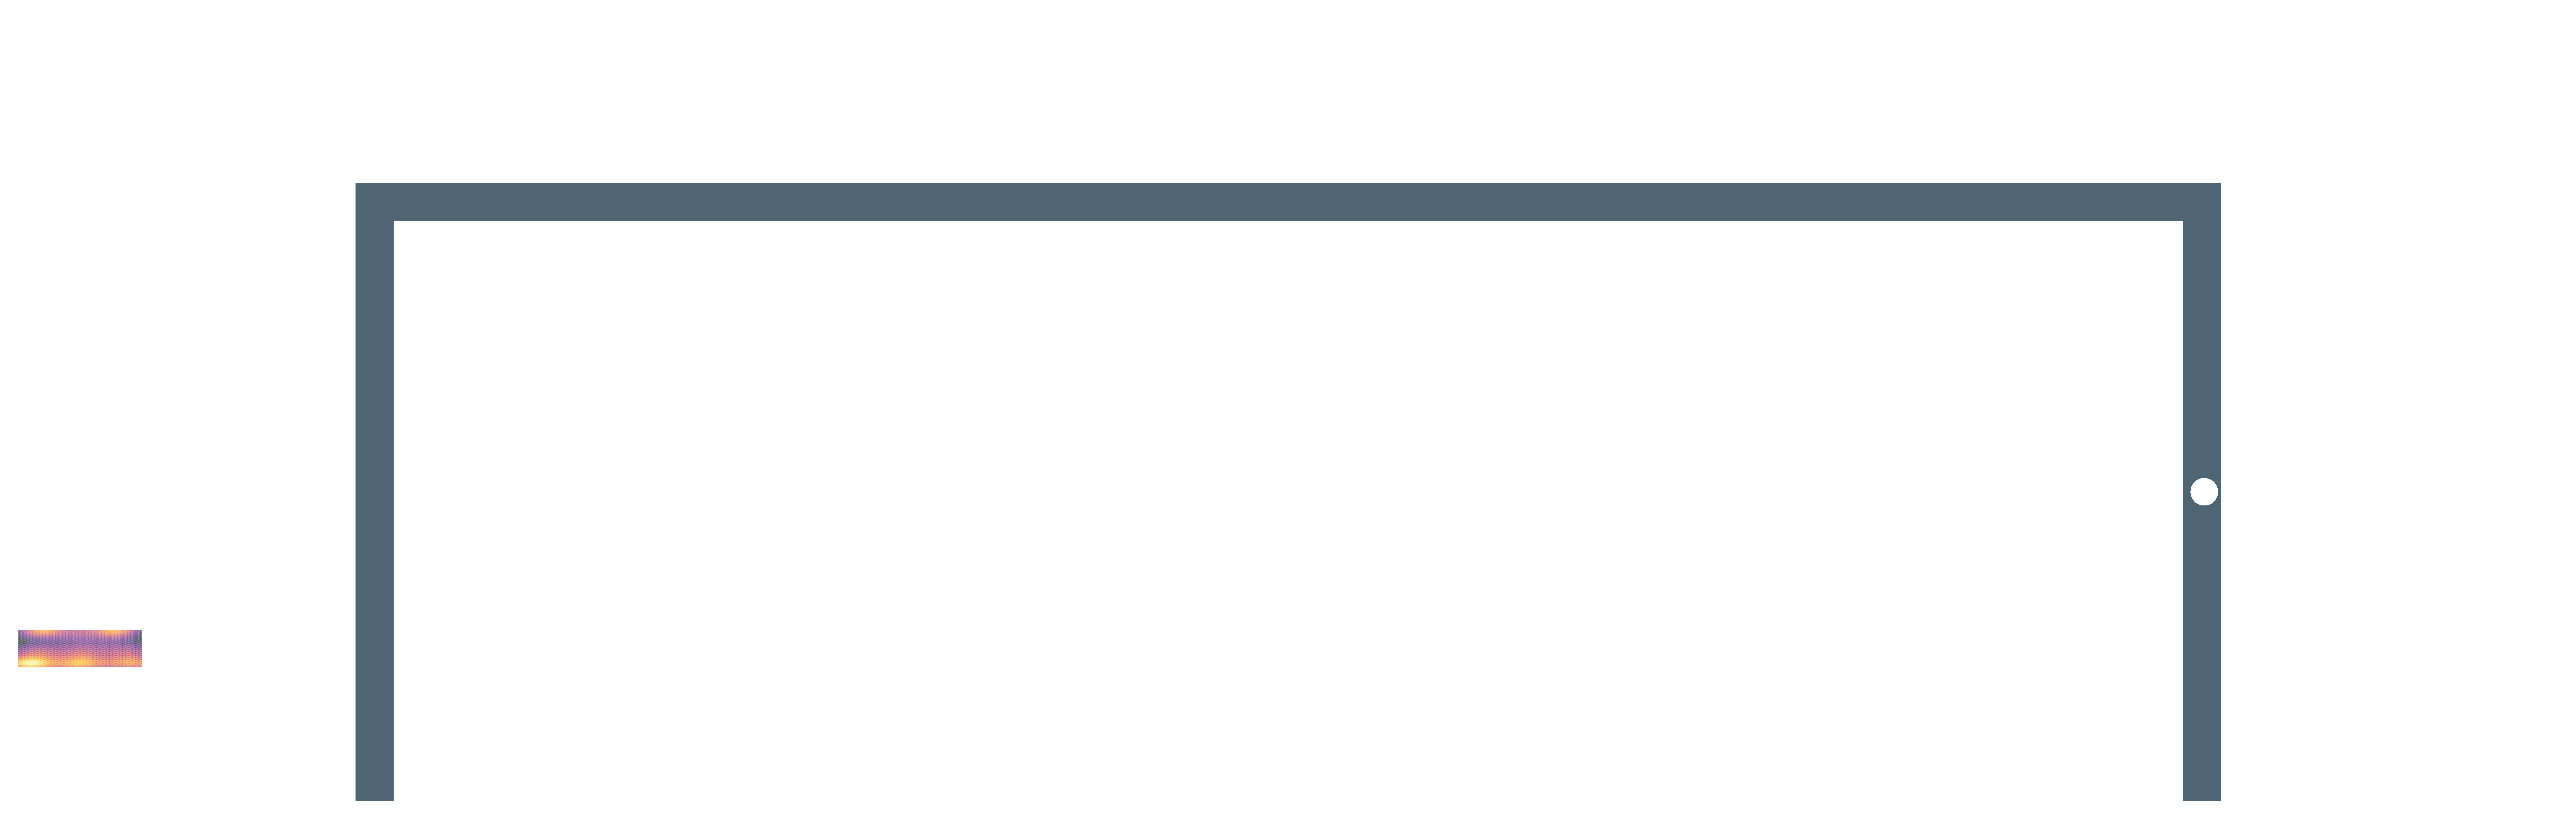

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from PIL import Image
import matplotlib.patches as patches

# Your existing data preparation
x = np.array(x)
y = np.array(y)

data = np.vstack([x, y])

nbins = 20

k = gaussian_kde(data)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# Load the background image
background_image = Image.open('/Users/michaelbertagna/Downloads/Hackathon Data/match-reports/existing-match-reports-code/goal.png')
width, height = background_image.size

# Create the figure and axes with the exact size of the image
fig, ax = plt.subplots(figsize=(width/100, height/100), dpi=100)

# Display the background image first
ax.imshow(background_image, extent=[0, width, 0, height], aspect='auto')

# Normalize the density values
zi_normalized = (zi - zi.min()) / (zi.max() - zi.min())

# Create the density plot overlay
density_plot = ax.pcolormesh(xi, yi, zi_normalized.reshape(xi.shape), 
                              cmap='inferno', 
                              alpha=0.5,  # Adjust transparency
                              shading='gouraud')

# Set the axis limits to match the image
ax.set_xlim(0, width)
ax.set_ylim(0, height)

# Remove axes
ax.axis('off')

# Adjust layout
plt.tight_layout(pad=0)

# Show or save the plot
plt.show()
# Uncomment to save
# plt.savefig('overlay_output.png', bbox_inches='tight', pad_inches=0, dpi=100)

In [9]:
data = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 3]], 200)
data

array([[-4.95411890e-01,  1.36312721e+00],
       [-9.65192312e-01,  8.07669250e-01],
       [ 1.55157101e+00,  1.89788512e+00],
       [ 2.80346814e-01, -1.03582986e+00],
       [ 9.19971194e-01,  9.88945562e-01],
       [ 8.50550121e-01, -3.65729761e+00],
       [-5.81009765e-01, -2.08877715e-01],
       [ 8.30873381e-03,  4.63041032e-01],
       [ 7.78175806e-02,  2.39901560e+00],
       [ 1.97683491e-01,  1.44653279e+00],
       [-6.36522105e-02,  9.44914662e-01],
       [ 1.27777631e-01,  1.22571447e+00],
       [ 1.71197227e+00,  1.61985418e-01],
       [-2.05960543e-01,  3.57070207e+00],
       [-3.33684289e-01,  1.26673360e+00],
       [ 1.34534351e+00, -6.42474122e-02],
       [-7.02000811e-01, -8.67128776e-01],
       [ 7.03316012e-02, -5.03187550e-01],
       [-3.46762483e-01,  2.55822395e-01],
       [-1.97860391e+00, -1.54252807e+00],
       [ 9.31613599e-01,  3.88241391e-01],
       [-2.21227633e-01, -8.52863557e-01],
       [ 1.00032644e+00, -1.35895079e-01],
       [-4.

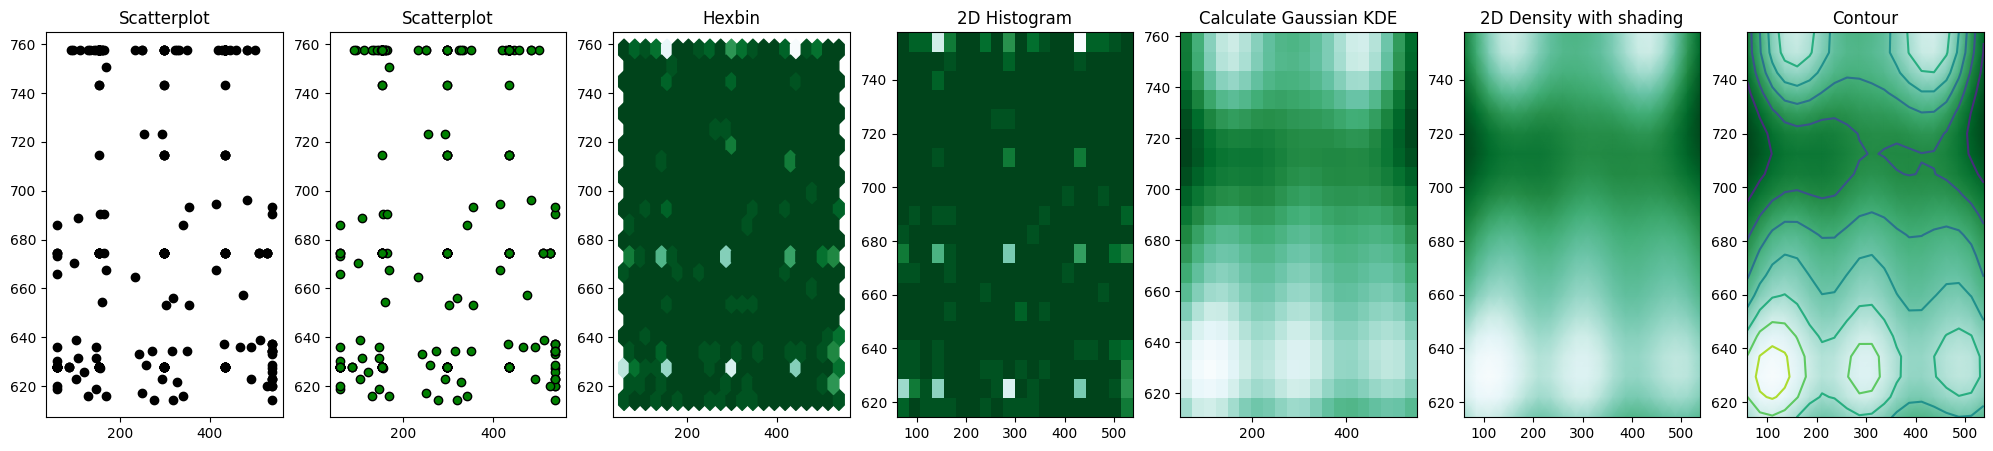

In [ ]:
x = np.array(x)
y = np.array(y)

data = np.vstack([x, y])
 
# Create a figure with 6 plot areas
fig, axes = plt.subplots(ncols=7, nrows=1, figsize=(25, 5))
 
# Everything starts with a Scatterplot
axes[0].set_title('Scatterplot')
axes[0].plot(x, y, 'ko')
# As you can see there is a lot of overlapping here!

# Everything starts with a Scatterplot
axes[1].set_title('Scatterplot')
axes[1].scatter(x, y, color='green', edgecolor='black')
 
# Thus we can cut the plotting window in several hexbins
nbins = 20
axes[2].set_title('Hexbin')
axes[2].hexbin(x, y, gridsize=nbins, cmap=plt.cm.BuGn_r)
 
# 2D Histogram
axes[3].set_title('2D Histogram')
axes[3].hist2d(x, y, bins=nbins, cmap=plt.cm.BuGn_r)
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = gaussian_kde(data)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# plot a density
axes[4].set_title('Calculate Gaussian KDE')
axes[4].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=plt.cm.BuGn_r)
 
# add shading
axes[5].set_title('2D Density with shading')
axes[5].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
 
# contour
axes[6].set_title('Contour')
axes[6].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
axes[6].contour(xi, yi, zi.reshape(xi.shape) )

plt.show()

In [ ]:
set(pts)

{4, 5, 8, 9, 10, 14, 16, 22, 27}

In [ ]:
import statistics

statistics.mode(pts)

9

In [ ]:
pts.count(statistics.mode(pts))

3172